In [64]:
# Import additional libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import warnings
warnings.filterwarnings('ignore') 

In [2]:
loan_df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)

In [3]:
print("Dataset Shape:", loan_df.shape)
print("First 5 rows:\n", loan_df.head())

Dataset Shape: (2260701, 151)
First 5 rows:
          id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   


## Data Cleaning

# Missing values
missing = loan_df.isnull().sum()
missing_pct = (missing / len(loan_df)) * 100
print("Missing Values (%):\n", pd.DataFrame({'Count': missing, 'Percentage': missing_pct}).sort_values(by='Count', ascending=False).head(20))

In [8]:
# Initial cleaning decisions
# Drop columns with >90% missing (adjust threshold as needed)
drop_cols = [col for col in loan_df.columns if missing_pct[col] > 90]
loan_df_clean = loan_df.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} columns with >90% missing. New shape:", loan_df_clean.shape)


Dropped 38 columns with >90% missing. New shape: (2260701, 113)


In [9]:
# Check duplicates
print("Duplicate Rows:", loan_df_clean.duplicated().sum())
loan_df_clean = loan_df_clean.drop_duplicates()  # Remove if any


Duplicate Rows: 0


In [10]:
# Check inconsistencies (example: negative values in key numeric cols)
numeric_cols = ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'int_rate']
for col in numeric_cols:
    if (loan_df_clean[col] < 0).any():
        print(f"Negative values found in {col}")
    else:
        print(f"No negative values in {col}")


No negative values in loan_amnt
No negative values in annual_inc
Negative values found in dti
No negative values in fico_range_low
No negative values in int_rate


In [11]:
# Handle specific cases (e.g., 'dti' has 33 missing from earlier output)
loan_df_clean['dti'].fillna(loan_df_clean['dti'].median(), inplace=True)  # Impute with median

## Data Profiling & Exploratory Data Analysis (EDA)


In [12]:
# Define default status for EDA (simplified binary for now)
loan_df_clean['default'] = loan_df_clean['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0 if x == 'Fully Paid' else np.nan
)
eda_df = loan_df_clean.dropna(subset=['default'])  # Drop 'Current', 'Late', etc. for now
print("EDA Dataset Shape (after dropping non-final statuses):", eda_df.shape)
print("Default Rate:", eda_df['default'].mean())


EDA Dataset Shape (after dropping non-final statuses): (1345350, 114)
Default Rate: 0.19964990522912254


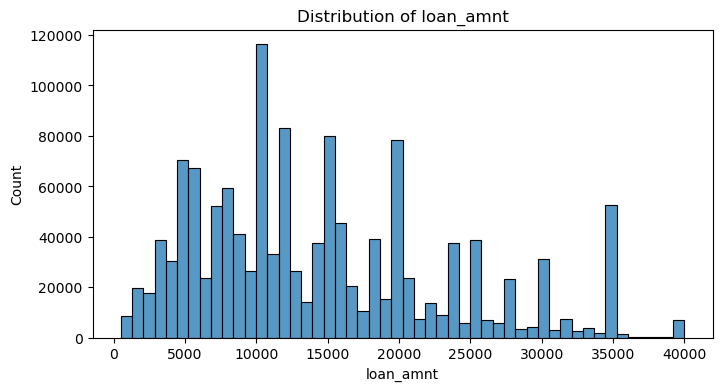

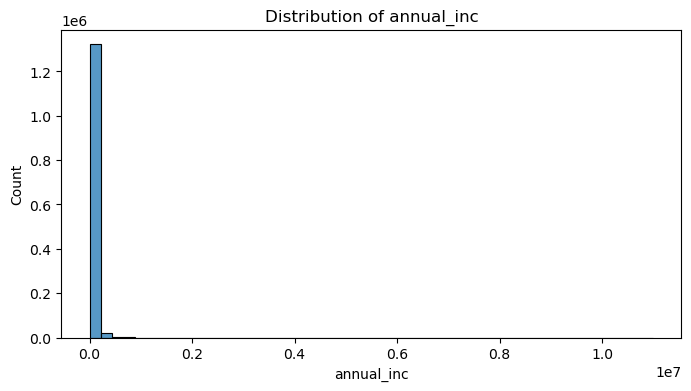

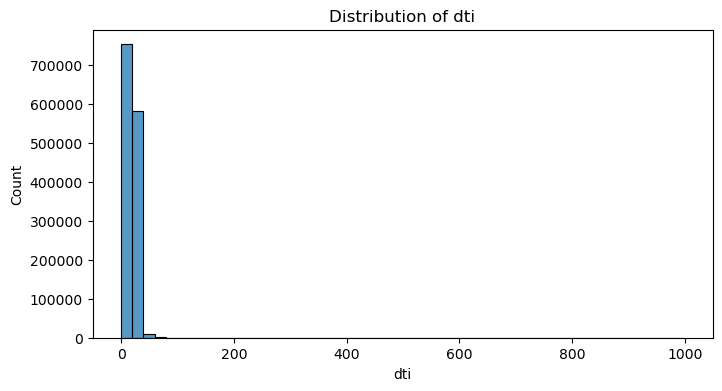

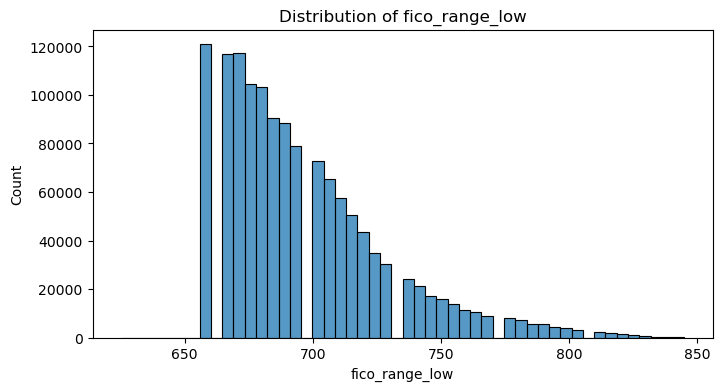

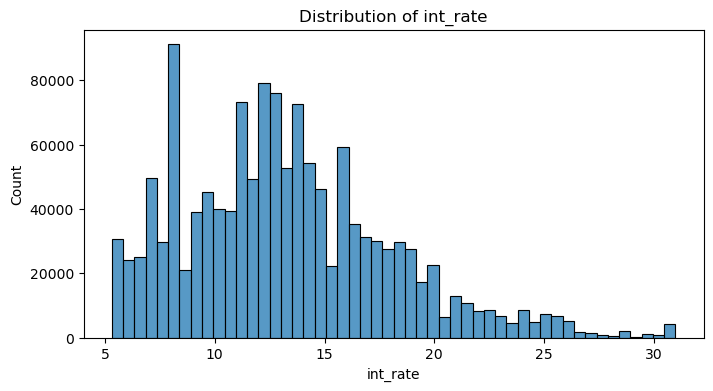

In [13]:
# Univariate: Histograms for key numeric features
key_numeric = ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'int_rate']
for col in key_numeric:
    plt.figure(figsize=(8, 4))
    sns.histplot(eda_df[col].dropna(), bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


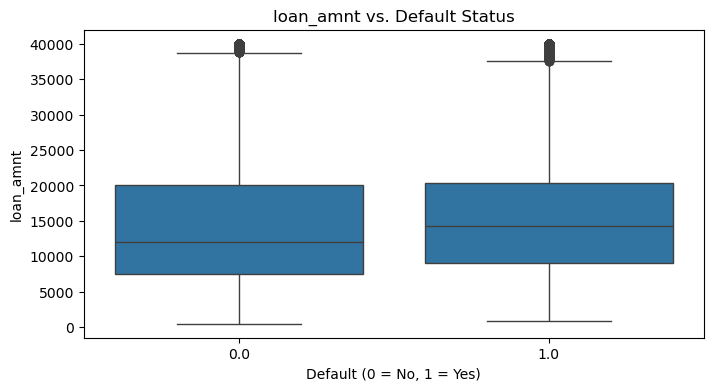

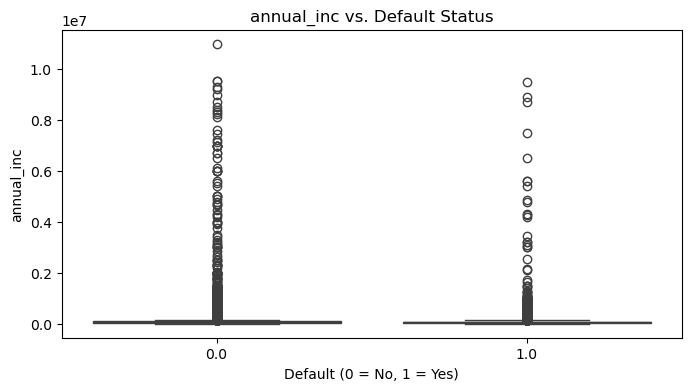

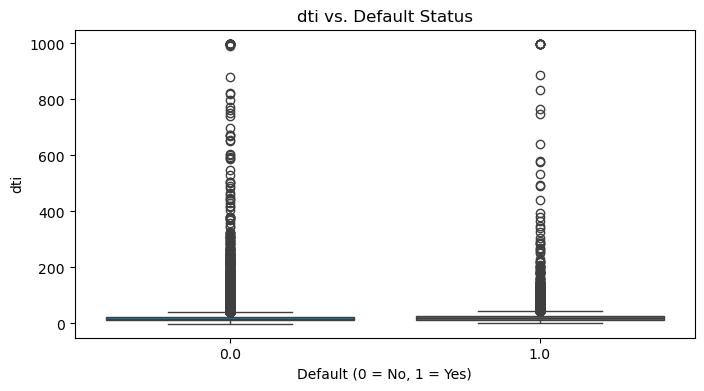

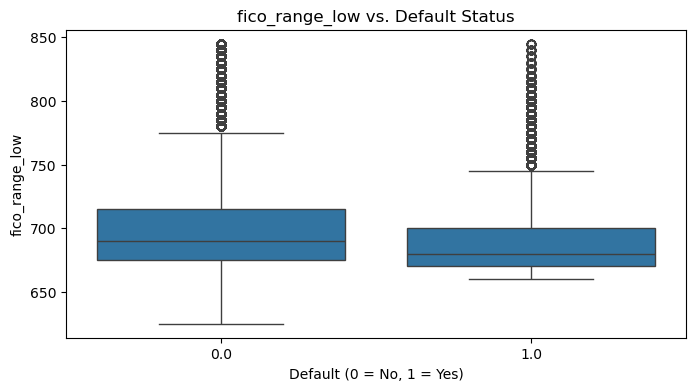

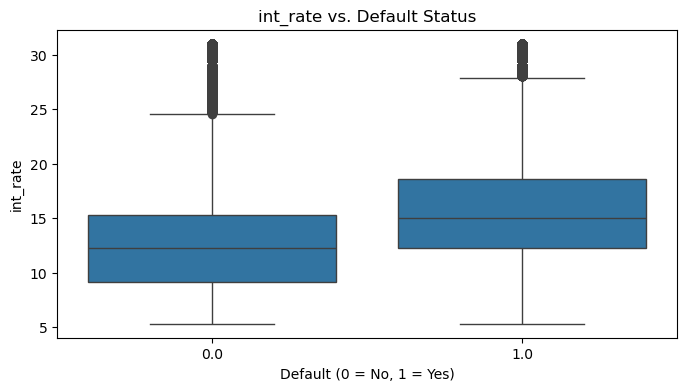

In [16]:
# Bivariate: Boxplots vs. default status
for col in key_numeric:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='default', y=col, data=eda_df)
    plt.title(f'{col} vs. Default Status')
    plt.xlabel('Default (0 = No, 1 = Yes)')
    plt.ylabel(col)
    plt.show()


In [17]:
# Domain check: FICO range (should be 300–850)
print("FICO Range Low - Min/Max:", eda_df['fico_range_low'].min(), "/", eda_df['fico_range_low'].max())

FICO Range Low - Min/Max: 625.0 / 845.0


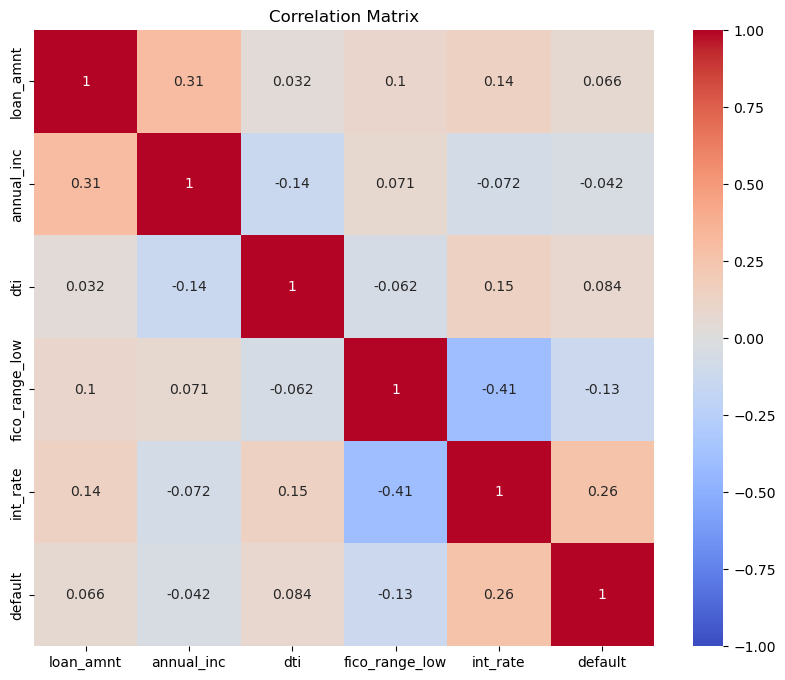

In [18]:
# Correlation check
corr = eda_df[key_numeric + ['default']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Fixing issues so far

In [19]:
loan_df_clean['dti'] = loan_df_clean['dti'].apply(lambda x: max(x, 0))  # Set negatives to 0
print("Negative dti values fixed. Min dti:", loan_df_clean['dti'].min())

Negative dti values fixed. Min dti: 0.0


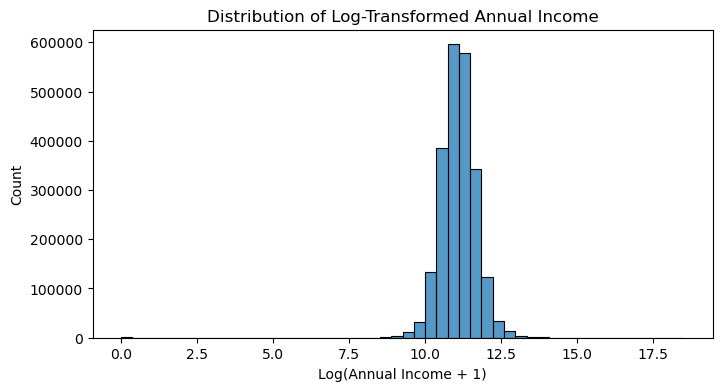

In [20]:
# Log-transform annual_inc to handle skewness
loan_df_clean['annual_inc_log'] = np.log1p(loan_df_clean['annual_inc'])  # log1p handles zeros
plt.figure(figsize=(8, 4))
sns.histplot(loan_df_clean['annual_inc_log'].dropna(), bins=50)
plt.title('Distribution of Log-Transformed Annual Income')
plt.xlabel('Log(Annual Income + 1)')
plt.ylabel('Count')
plt.show()


In [21]:
# Recalculate default for EDA with cleaned data
loan_df_clean['default'] = loan_df_clean['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0 if x == 'Fully Paid' else np.nan
)
eda_df = loan_df_clean.dropna(subset=['default'])
print("Updated EDA Dataset Shape:", eda_df.shape)
print("Updated Default Rate:", eda_df['default'].mean())

Updated EDA Dataset Shape: (1345350, 115)
Updated Default Rate: 0.19964990522912254


# 3A: Encode Categorical Variables

In [22]:
# Select categorical columns to encode (low cardinality to avoid explosion)
categorical_cols = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'term']
loan_df_clean = pd.get_dummies(loan_df_clean, columns=categorical_cols, drop_first=True)

In [23]:
# Drop non-useful columns (e.g., dates, IDs, post-loan outcomes)
drop_cols = ['id', 'member_id', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line', 'total_pymnt', 'total_rec_prncp', 'total_rec_int']
loan_df_clean = loan_df_clean.drop(columns=drop_cols, errors='ignore')


# Step 3B: Feature Scaling

In [24]:
scaler = StandardScaler()
numeric_cols_scaled = ['loan_amnt', 'annual_inc_log', 'dti', 'fico_range_low', 'int_rate', 'installment', 'revol_bal']
loan_df_clean[numeric_cols_scaled] = scaler.fit_transform(loan_df_clean[numeric_cols_scaled])
print("Scaled Numeric Columns:", numeric_cols_scaled)


Scaled Numeric Columns: ['loan_amnt', 'annual_inc_log', 'dti', 'fico_range_low', 'int_rate', 'installment', 'revol_bal']


# Step 3C: Refine Default Definition and Handle Class Imbalance

In [25]:
# For modeling, we'll exclude "Current" and late statuses, keeping only "Fully Paid" and "Charged Off/Default"
loan_df_clean['default'] = loan_df_clean['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0 if x == 'Fully Paid' else np.nan
)
model_df = loan_df_clean.dropna(subset=['default'])
print("Modeling Dataset Shape:", model_df.shape)
print("Final Default Rate:", model_df['default'].mean())


Modeling Dataset Shape: (1345350, 162)
Final Default Rate: 0.19964990522912254


# Train-Test Split (70-30 split)

In [26]:
X = model_df.drop(columns=['default', 'loan_status'])  # Drop target and original status
y = model_df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

Training Shape: (941745, 160)
Testing Shape: (403605, 160)


# Step 3D: Advanced Feature Engineering

In [27]:
# Create ratios and behavioral features
X_train['loan_to_income'] = X_train['loan_amnt'] / np.expm1(X_train['annual_inc_log'])  # Reverse log1p for ratio
X_test['loan_to_income'] = X_test['loan_amnt'] / np.expm1(X_test['annual_inc_log'])
X_train['credit_util'] = X_train['revol_bal'] / X_train['fico_range_low']  # Proxy for credit utilization
X_test['credit_util'] = X_test['revol_bal'] / X_test['fico_range_low']

In [28]:
# Scale new features
new_features = ['loan_to_income', 'credit_util']
X_train[new_features] = scaler.fit_transform(X_train[new_features])
X_test[new_features] = scaler.transform(X_test[new_features])

In [33]:
# Handle class imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced Training Shape:", X_train_balanced.shape)
print("Balanced Default Rate:", y_train_balanced.mean())

ValueError: could not convert string to float: 'owner'

## fixing SMOTE issue

In [34]:
# Check for non-numeric columns in X_train
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns in X_train:", non_numeric_cols)

Non-numeric columns in X_train: Index(['emp_title', 'emp_length', 'pymnt_plan', 'url', 'title', 'zip_code',
       'addr_state', 'initial_list_status', 'next_pymnt_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


In [35]:
# Drop non-numeric or high-cardinality columns
drop_cols = ['emp_title', 'pymnt_plan', 'url', 'title', 'zip_code', 'addr_state', 
             'initial_list_status', 'next_pymnt_d', 'debt_settlement_flag']
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

In [36]:
# Encode emp_length as ordinal
emp_length_mapping = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
    '10+ years': 10
}
X_train['emp_length'] = X_train['emp_length'].map(emp_length_mapping)
X_test['emp_length'] = X_test['emp_length'].map(emp_length_mapping)

In [37]:
# Encode application_type (Individual=0, Joint=1)
X_train['application_type'] = X_train['application_type'].map({'Individual': 0, 'Joint App': 1})
X_test['application_type'] = X_test['application_type'].map({'Individual': 0, 'Joint App': 1})


In [38]:
# Encode hardship_flag (N=0, Y=1)
X_train['hardship_flag'] = X_train['hardship_flag'].map({'N': 0, 'Y': 1})
X_test['hardship_flag'] = X_test['hardship_flag'].map({'N': 0, 'Y': 1})


In [39]:
# One-hot encode disbursement_method
X_train = pd.get_dummies(X_train, columns=['disbursement_method'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['disbursement_method'], drop_first=True)


In [40]:
# Verify no non-numeric columns remain
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns after cleanup:", non_numeric_cols)
if len(non_numeric_cols) > 0:
    print("Remaining non-numeric columns need to be encoded or dropped!")
else:
    print("All columns are numeric—ready for SMOTE!")

Non-numeric columns after cleanup: Index([], dtype='object')
All columns are numeric—ready for SMOTE!


In [41]:
# Re-run SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced Training Shape:", X_train_balanced.shape)
print("Balanced Default Rate:", y_train_balanced.mean())

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [42]:
# Check for NaNs in X_train
nan_cols = X_train.isna().sum()
nan_cols = nan_cols[nan_cols > 0]
print("Columns with NaNs in X_train:\n", nan_cols)
print("Total rows in X_train:", len(X_train))

Columns with NaNs in X_train:
 emp_length                         54941
inq_last_6mths                         1
mths_since_last_delinq            475115
mths_since_last_record            782034
revol_util                           610
collections_12_mths_ex_med            43
mths_since_last_major_derog       693960
tot_coll_amt                       47400
tot_cur_bal                        47400
open_acc_6m                       565395
open_act_il                       565394
open_il_12m                       565394
open_il_24m                       565394
mths_since_rcnt_il                575318
total_bal_il                      565394
il_util                           616026
open_rv_12m                       565394
open_rv_24m                       565394
max_bal_bc                        565394
all_util                          565427
total_rev_hi_lim                   47400
inq_fi                            565394
total_cu_tl                       565395
inq_last_12m              

In [43]:
# Drop columns with >50% missing values
drop_cols = [
    'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
    'il_util', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
    'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
    'total_cu_tl', 'inq_last_12m'
]
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

In [44]:
# Impute remaining NaNs with median
numeric_cols_to_impute = X_train.columns[X_train.isna().any()].tolist()  # All columns with NaNs
for col in numeric_cols_to_impute:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_test[col].median())

In [45]:
# Verify no NaNs remain
nan_cols_after = X_train.isna().sum()
nan_cols_after = nan_cols_after[nan_cols_after > 0]
print("Columns with NaNs after imputation:\n", nan_cols_after)
print("Total columns in X_train:", len(X_train.columns))

Columns with NaNs after imputation:
 Series([], dtype: int64)
Total columns in X_train: 136


In [46]:
# Re-run SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Balanced Training Shape:", X_train_balanced.shape)
print("Balanced Default Rate:", y_train_balanced.mean())

Balanced Training Shape: (1507452, 136)
Balanced Default Rate: 0.5


# Step 4A: Model Selection - Logistic Regression

In [49]:
# Train logistic regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000, random_state=42)

# Step 4D: Evaluate Baseline Model

In [50]:
# Predict probabilities and labels on test set
y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)

In [51]:
# AUC and Gini
auc = roc_auc_score(y_test, y_pred_proba)
gini = 2 * auc - 1
print("AUC:", auc)
print("Gini:", gini)

AUC: 0.9981440830582258
Gini: 0.9962881661164515


In [52]:
# Classification report (precision, recall, F1)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    323025
         1.0       0.98      0.98      0.98     80580

    accuracy                           0.99    403605
   macro avg       0.99      0.99      0.99    403605
weighted avg       0.99      0.99      0.99    403605



In [53]:
# Kolmogorov-Smirnov (KS) Statistic
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ks_statistic = max(tpr - fpr)
print("KS Statistic:", ks_statistic)

KS Statistic: 0.9800874343618471


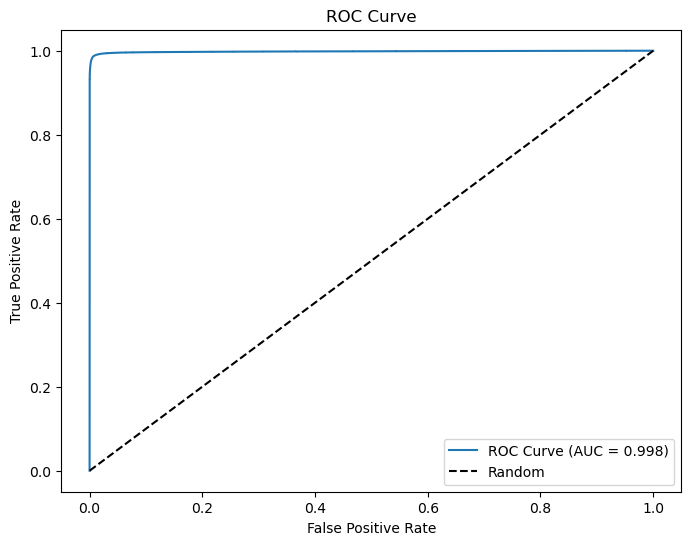

In [54]:
# Optional: Plot ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [55]:
# Re-verify features for leakage
print("Remaining columns in X_train:", X_train.columns.tolist())

Remaining columns in X_train: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl

In [56]:
# Recalculate KS Statistic
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ks_statistic = max(tpr - fpr)
print("KS Statistic:", ks_statistic)

KS Statistic: 0.9800874343618471


In [57]:
# Optional: Try without SMOTE (using class weights)
lr_no_smote = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_no_smote.fit(X_train, y_train)
y_pred_proba_no_smote = lr_no_smote.predict_proba(X_test)[:, 1]
y_pred_no_smote = lr_no_smote.predict(X_test)
auc_no_smote = roc_auc_score(y_test, y_pred_proba_no_smote)
gini_no_smote = 2 * auc_no_smote - 1
print("AUC without SMOTE:", auc_no_smote)
print("Gini without SMOTE:", gini_no_smote)
print("Classification Report without SMOTE:\n", classification_report(y_test, y_pred_no_smote))

AUC without SMOTE: 0.997945459116168
Gini without SMOTE: 0.9958909182323361
Classification Report without SMOTE:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    323025
         1.0       0.98      0.98      0.98     80580

    accuracy                           0.99    403605
   macro avg       0.99      0.99      0.99    403605
weighted avg       0.99      0.99      0.99    403605



# Leakage Suspected

In [58]:
# Identify and drop post-loan/leakage columns
leakage_cols = [
    'total_pymnt_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'out_prncp',
    'out_prncp_inv'
]
X_train = X_train.drop(columns=leakage_cols, errors='ignore')
X_test = X_test.drop(columns=leakage_cols, errors='ignore')

In [59]:
# Re-train logistic regression with SMOTE
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_balanced.drop(columns=leakage_cols, errors='ignore'), y_train_balanced)


LogisticRegression(max_iter=1000, random_state=42)

In [60]:
# Re-evaluate
y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)
auc = roc_auc_score(y_test, y_pred_proba)
gini = 2 * auc - 1
print("AUC after removing leakage:", auc)
print("Gini after removing leakage:", gini)
print("Classification Report after removing leakage:\n", classification_report(y_test, y_pred))


AUC after removing leakage: 0.631735467047406
Gini after removing leakage: 0.26347093409481204
Classification Report after removing leakage:
               precision    recall  f1-score   support

         0.0       0.86      0.55      0.67    323025
         1.0       0.26      0.64      0.37     80580

    accuracy                           0.57    403605
   macro avg       0.56      0.59      0.52    403605
weighted avg       0.74      0.57      0.61    403605



In [61]:
# Re-calculate KS Statistic
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ks_statistic = max(tpr - fpr)
print("KS Statistic after removing leakage:", ks_statistic)


KS Statistic after removing leakage: 0.19066796835088634


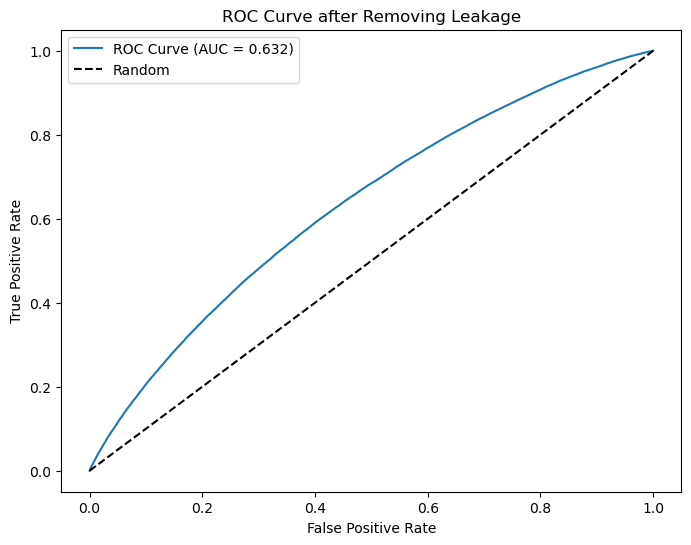

In [62]:
# Optional: Plot new ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after Removing Leakage')
plt.legend()
plt.show()



# Step 5A: Advanced Modeling with XGBoost

In [65]:
# Train XGBoost with SMOTE
xgb_smote = XGBClassifier(random_state=42, eval_metric='auc', scale_pos_weight=1)
xgb_smote.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [66]:
# Predict and evaluate
y_pred_proba_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]
y_pred_xgb_smote = xgb_smote.predict(X_test)
auc_xgb_smote = roc_auc_score(y_test, y_pred_proba_xgb_smote)
gini_xgb_smote = 2 * auc_xgb_smote - 1
print("XGBoost with SMOTE - AUC:", auc_xgb_smote)
print("XGBoost with SMOTE - Gini:", gini_xgb_smote)
print("XGBoost with SMOTE - Classification Report:\n", classification_report(y_test, y_pred_xgb_smote))

ValueError: feature_names mismatch: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'hardship_flag', 'annual_inc_log', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'term_ 60 months', 'loan_to_income', 'credit_util', 'disbursement_method_DirectPay'] ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'hardship_flag', 'annual_inc_log', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'term_ 60 months', 'loan_to_income', 'credit_util', 'disbursement_method_DirectPay']
expected last_pymnt_amnt, out_prncp, out_prncp_inv, last_fico_range_high, collection_recovery_fee, last_fico_range_low, recoveries, total_rec_late_fee, total_pymnt_inv in input data